Original script: https://zenodo.org/records/4090925

In [ ]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Optional, Union

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection

import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx
import biotite.structure.io.pdb as pdbio


In [9]:

RADIUS = 1.2
MARGIN = 5.0
CB_FUDGE = 1.2
SCALE = 10.0

LW_LOOP  = 1.5
LW_HELIX = 3.5
LW_BETA  = 3.5
LW_SIDE  = 1.5
LW_EDGE  = 1.5

AA_FONTSIZE = 11
RESI_FONTSIZE = 9
LABEL_EVERY = 2

DEFAULT_FIGSIZE = (10, 10)
DEFAULT_DPI = 200

AA1 = {
    "ARG":"R","HIS":"H","LYS":"K","ASP":"D","GLU":"E","SER":"S","THR":"T",
    "ASN":"N","GLN":"Q","CYS":"C","GLY":"G","PRO":"P","ALA":"A","VAL":"V",
    "ILE":"I","LEU":"L","MET":"M","PHE":"F","TYR":"Y","TRP":"W"
}
AA_CLASS = {
    "ARG":"b","HIS":"b","LYS":"b","ASP":"a","GLU":"a",
    "SER":"w","THR":"w","ASN":"w","GLN":"w","CYS":"s",
    "GLY":"g","PRO":"p","ALA":"n","VAL":"n","ILE":"n",
    "LEU":"n","MET":"s","PHE":"n","TYR":"n","TRP":"n"
}
CLASS_TO_FILL = {"a":"red","b":"skyblue","w":"green","g":"pink","n":"white","s":"yellow","p":"purple"}


def aa1(res3: str) -> str:
    return AA1.get(res3.upper(), "X")


def aa_class(res3: str) -> str:
    return AA_CLASS.get(res3.upper(), "n")


In [10]:
@dataclass(frozen=True)
class StructureBundle:
    """Bundle atomarray for calculation, pdbx_file for annotation (sse)
    """
    arr: struc.AtomArray
    pdbx_file: Optional[pdbx.CIFFile] = None


def load_structure(source: Union[str, Path], *, model: int = 1) -> StructureBundle:
    """
    source: PDB ID (e.g. "7KWZ") or .cif/.pdb path.
    Returns AtomArray + (optionally) CIFFile (useful for SSE annotations).
    """
    s = str(source)

    # PDB ID
    if len(s) == 4 and s.isalnum() and not Path(s).exists():
        pdb_id = s.upper()
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
        return StructureBundle(arr=arr, pdbx_file=cif)

    # Local files
    p = Path(s)
    if p.suffix.lower() in {".cif", ".bcif"}:
        cif = pdbx.CIFFile.read(str(p))
        arr = pdbx.get_structure(cif, model=model)
        return StructureBundle(arr=arr, pdbx_file=cif)

    if p.suffix.lower() == ".pdb":
        pdb = pdbio.PDBFile.read(str(p))
        arr = pdbio.get_structure(pdb, model=model)
        return StructureBundle(arr=arr, pdbx_file=None)

    raise ValueError(f"Unsupported source: {source}")


def select_chain_amino_acids(arr: struc.AtomArray, chain_id: str) -> struc.AtomArray:
    m = struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)
    aa = arr[m]
    if aa.array_length() == 0:
        raise ValueError(f"No amino-acid atoms found for chain '{chain_id}'.")
    return aa


In [11]:
# Per-residue geometry (2D)
def _ins_code_or_empty(aa: struc.AtomArray) -> np.ndarray:
    # in case there is insertion code, use it for stable sorting; otherwise, use empty string
    ins = getattr(aa, "ins_code", None)
    if ins is None:
        return np.array([""] * aa.array_length(), dtype=object)
    return ins.astype(str)


def residue_xy(aa: struc.AtomArray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns (res_ids, res_names, ca_xy, cb_xy) in a stable residue order.
    cb_xy is NaN for residues without CB (except GLY uses CA).
    """
    ins = _ins_code_or_empty(aa)

    # stable sort: residue first, then insertion, then atom name
    order = np.lexsort((aa.atom_name.astype(str), ins, aa.res_id.astype(int)))
    aa = aa[order]

    # the ATOM index for each residue
    starts = struc.get_residue_starts(aa) # [ 0  16  35  56  75  92 116 135 157 169 176 183 197 208 219 226 250 264]
    # the ATOM index for the next residue (or end of array for the last residue)
    stops = np.append(starts[1:], aa.array_length()) # [ 16  35  56  75  92 116 135 157 169 176 183 197 208 219 226 250 264 282]
    print(f"found {len(starts)} residues (including insertion codes)")
    print(f"residue IDs (first 10): {aa.res_id[starts][:10]}")
    print(f"stops (first 10): {stops[:10]}")

    res_ids, res_names, ca_xy, cb_xy = [], [], [], []
    for s, e in zip(starts, stops):
        # zip to get residue-specific atom array
        r = aa[s:e]
        # get the residue ID of this residue array
        rid = int(r.res_id[0])
        # get the residue name of this residue array
        rn = str(r.res_name[0]).upper()

        ca = r[r.atom_name == "CA"]
        if ca.array_length() == 0:
            # skip residues without CA (e.g. N-terminal residue, or incomplete residues)
            continue

        ca2 = ca.coord[0, :2].astype(float)
        if rn == "GLY":
            # glycine has no CB, so use CA coordinate for CB
            cb2 = ca2
        else:
            cb = r[r.atom_name == "CB"]
            # if CB is missing, use NaN to indicate missing CB (e.g. incomplete residues)
            cb2 = cb.coord[0, :2].astype(float) if cb.array_length() else np.array([np.nan, np.nan], float)

        res_ids.append(rid)
        res_names.append(rn)
        ca_xy.append(ca2)
        cb_xy.append(cb2)

    return (
        np.asarray(res_ids, int),
        np.asarray(res_names, dtype="<U3"),
        np.asarray(ca_xy, float),
        np.asarray(cb_xy, float),
    )


In [12]:

# SSE (H/E/-)
def sse_to_coarse(c: str) -> str:
    if c in ("E", "B", "b"):
        return "E"
    if c in ("H", "G", "I", "a"):
        return "H"
    return "-"


def sse_by_residue(
    aa: struc.AtomArray,
    chain_id: str,
    *,
    pdbx_file: Optional[pdbx.CIFFile] = None,
) -> dict[int, str]:
    """
    Map res_id -> coarse SSE ("H","E","-") for residues present in `aa`.
    Tries PDBx annotations first, then DSSP; otherwise all '-'.
    """
    starts = struc.get_residue_starts(aa)
    res_ids = aa.res_id[starts].astype(int)

    # 1) PDBx-provided SSE (if present)
    if pdbx_file is not None:
        try:
            sse_map = pdbx.get_sse(pdbx_file)
            if chain_id in sse_map:
                raw = np.asarray(list(sse_map[chain_id]), dtype="<U1")
                coarse = np.array([sse_to_coarse(x) for x in raw], dtype="<U1")
                m = min(len(res_ids), len(coarse))
                return {int(res_ids[i]): str(coarse[i]) for i in range(m)}
        except Exception:
            pass

    # 2) DSSP (requires DSSP binary available)
    try:
        from biotite.application.dssp import DsspApp
        app = DsspApp(aa)
        app.start(); app.join()
        raw = np.asarray(list(app.get_sse()), dtype="<U1")
        coarse = np.array([sse_to_coarse(x) for x in raw], dtype="<U1")
        m = min(len(res_ids), len(coarse))
        return {int(res_ids[i]): str(coarse[i]) for i in range(m)}
    except Exception:
        return {int(r): "-" for r in res_ids}


In [13]:

# Plot
def plot_atom2svg_xy_sse(
    arr: struc.AtomArray,
    chain_id: str,
    *,
    pdbx_file: Optional[pdbx.CIFFile] = None,
    label_every: int = LABEL_EVERY,
    figsize: Tuple[float, float] = DEFAULT_FIGSIZE,
    dpi: int = DEFAULT_DPI,
) -> None:
    aa = select_chain_amino_acids(arr, chain_id)
    res_ids, res_names, ca_xy, cb_xy = residue_xy(aa)
    sse = sse_by_residue(aa, chain_id, pdbx_file=pdbx_file)

    # bbox from CA coords (atom2svg-ish)
    minx, miny = ca_xy.min(axis=0) - MARGIN
    maxx, maxy = ca_xy.max(axis=0) + MARGIN

    def T(xy: np.ndarray) -> Tuple[float, float]:
        x, y = np.asarray(xy, float).reshape(2)
        return (SCALE * (x - minx), SCALE * (y - miny))

    W = SCALE * (maxx - minx)
    H = SCALE * (maxy - miny)

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])

    # Backbone segments grouped by SSE
    seg_loop, seg_helix, seg_beta = [], [], []
    for i in range(1, len(res_ids)):
        tag = sse.get(int(res_ids[i]), "-")
        seg = [T(ca_xy[i]), T(ca_xy[i - 1])]
        (seg_helix if tag == "H" else seg_beta if tag == "E" else seg_loop).append(seg)

    if seg_loop:
        ax.add_collection(LineCollection(seg_loop, colors="black", linewidths=LW_LOOP,
                                         capstyle="round", joinstyle="round", antialiased=True, zorder=1))
    if seg_beta:
        ax.add_collection(LineCollection(seg_beta, colors="black", linewidths=LW_BETA,
                                         capstyle="round", joinstyle="round", antialiased=True, zorder=2))
    if seg_helix:
        ax.add_collection(LineCollection(seg_helix, colors="black", linewidths=LW_HELIX,
                                         linestyles=(0, (2, 2)),
                                         capstyle="round", joinstyle="round", antialiased=True, zorder=3))

    # Sidechain stems + beads
    side_segments = []
    r_disp = RADIUS * SCALE
    gap = 4.0

    for i, (rid, rn) in enumerate(zip(res_ids, res_names)):
        ca2 = ca_xy[i]
        cb2 = cb_xy[i]
        if np.isnan(cb2).any():
            continue

        if rn != "GLY":
            pos = CB_FUDGE * cb2 + (1.0 - CB_FUDGE) * ca2
            side_segments.append([T(pos), T(ca2)])
        else:
            pos = cb2

        cx, cy = T(pos)
        fill = CLASS_TO_FILL.get(aa_class(rn), "white")

        ax.add_patch(Circle((cx, cy), radius=r_disp,
                            facecolor=fill, edgecolor="black",
                            linewidth=LW_EDGE, antialiased=True, zorder=6))

        ax.text(cx, cy, aa1(rn), ha="center", va="center",
                fontsize=AA_FONTSIZE, family="sans-serif",
                color="black", zorder=7, fontweight="bold")

        if label_every > 0 and (i % label_every == 0) and rn != "GLY":
            v = np.array([cx, cy]) - np.array(T(ca2))
            u = v / (np.linalg.norm(v) + 1e-12)
            ax.text(cx + (r_disp + gap) * u[0], cy + (r_disp + gap) * u[1], str(int(rid)),
                    ha="center", va="center", fontsize=RESI_FONTSIZE,
                    family="sans-serif", color="black", zorder=7)

    if side_segments:
        ax.add_collection(LineCollection(side_segments, colors="black", linewidths=LW_SIDE,
                                         capstyle="round", joinstyle="round", antialiased=True, zorder=5))

    ax.set_xlim(0, W)
    ax.set_ylim(0, H)
    ax.set_aspect("equal")
    ax.axis("off")
    plt.show()



found 139 residues (including insertion codes)
residue IDs (first 10): [276 277 278 279 280 281 282 283 284 285]
stops (first 10): [11 15 19 27 34 38 42 53 57 65]


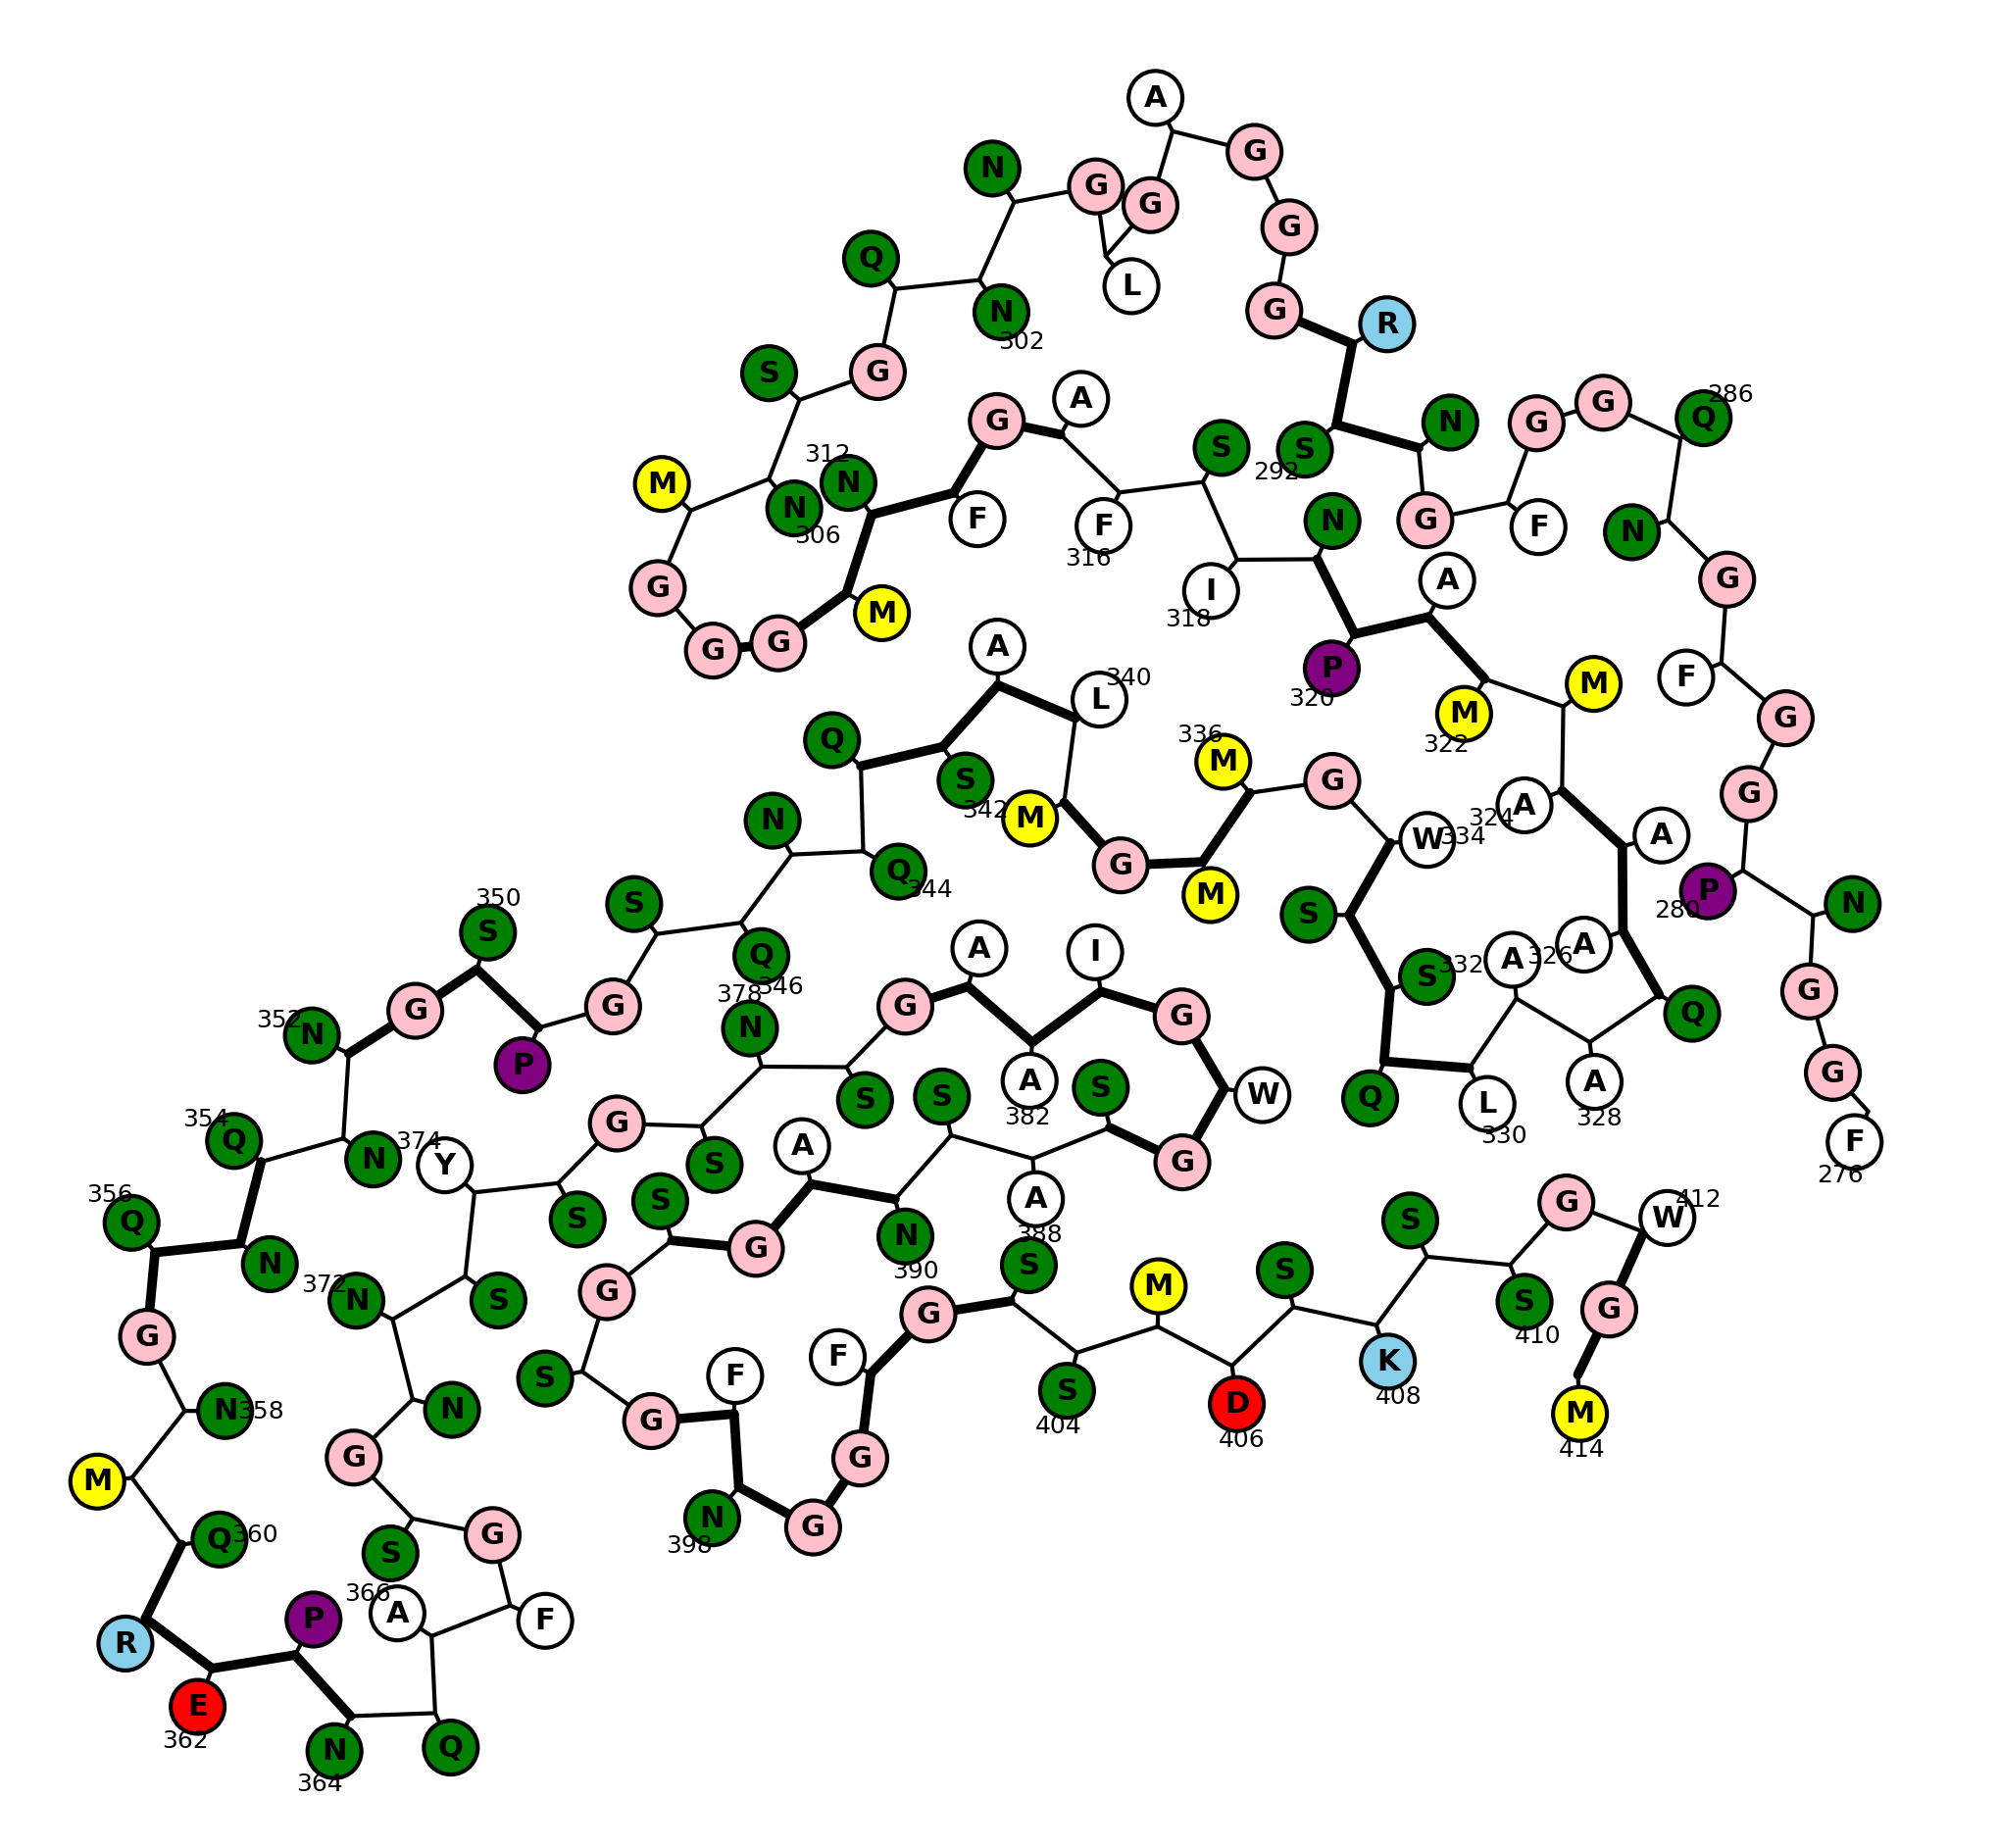

In [14]:
pdb_id = "7KWZ"
chain_id = "A"

bundle = load_structure(pdb_id, model=1)
plot_atom2svg_xy_sse(bundle.arr, chain_id, pdbx_file=bundle.pdbx_file,
                     label_every=2, figsize=(10, 10), dpi=200)
